In [18]:
import pandas as pd

df=pd.read_excel('human.xlsx')

#데이터 추출
date_row = df.iloc[0, 4:]  # 날짜 정보는 4번째 열부터 시작해서 마지막 까지 열, 0행
birth_row = df.iloc[1, 4:] # 출생아 수 정보는 4번째 열부터 시작해서 마지막 까지 열, 0행

date_row = date_row.str.replace(' 월', '', regex=False) #연도와 월만 남기고 없앰

#새로운 데이터 프레임 생성
birth_data = pd.DataFrame({
    'Date': date_row,
    '출생아수': birth_row
})



birth_data_cleaned = birth_data.dropna() # NA값 삭제

birth_data_cleaned.set_index('Date',inplace=True) #Date를 인덱스 설정
birth_data_cleaned.index.name = 'Date'

birth_data_cleaned

,출생아수
Date,
2015.01,41914
2015.02,35709
2015.03,40329
2015.04,38072
2015.05,36534
...,...
2024.02,19362
2024.03,19669
2024.04,19049


In [19]:
#한글 폰트 설정

import pandas as pd

import numpy as np

import matplotlib

import matplotlib.pyplot as plt

from prophet import Prophet

matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False 

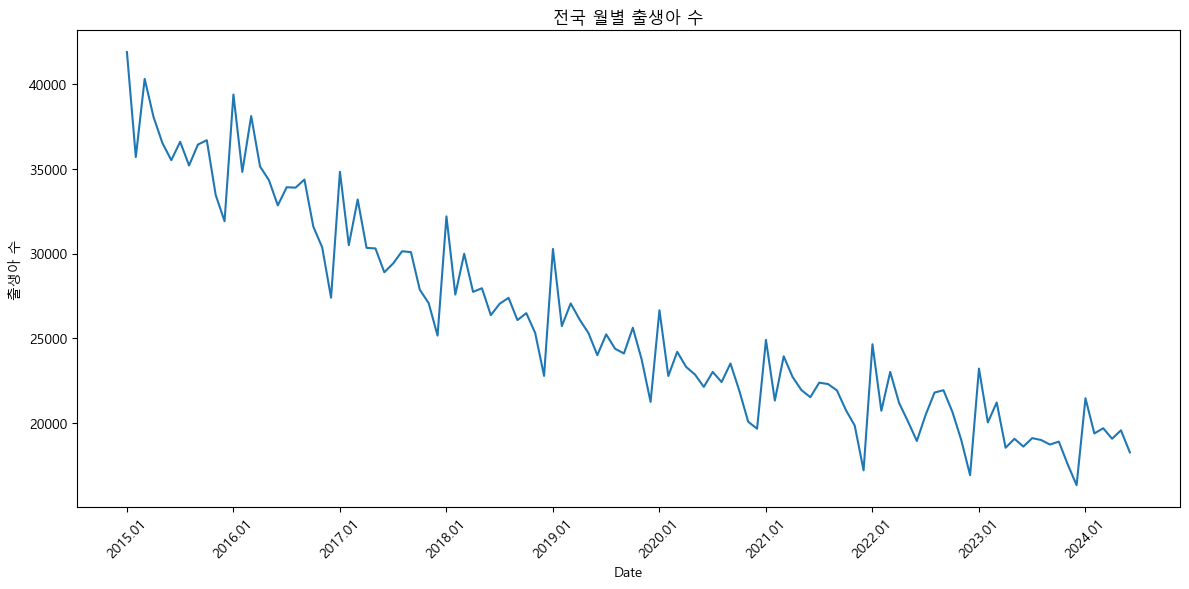

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(birth_data_cleaned.index, birth_data_cleaned['출생아수'])  
plt.title('전국 월별 출생아 수')
plt.xlabel('Date')
plt.ylabel('출생아 수')
plt.xticks(rotation=45)  
plt.tight_layout()

# 12개월마다 x축에 라벨을 표시
plt.xticks(ticks=range(0, len(birth_data_cleaned), 12), labels=birth_data_cleaned.index[::12], rotation=45)

plt.show()


In [22]:
# 인덱스를 리셋하여 'Date'를 열로 변환
df = birth_data_cleaned.reset_index()

# 새로운 데이터프레임 생성(트레인 셋과 테스트 셋을 적정 량으로 분리하여)
df1 = pd.DataFrame({'ds': df['Date'], 'y': df['출생아수']})

filt1=(df['Date']<'2023.01') # 2015/01~ 2022/12까지의 데이터 : train 셋으로 분할

filt2=(df['Date']>='2023.01') # 2023/01~ 2024/06까지의 데이터 : test 셋으로 분할

df2 = pd.DataFrame({'ds': df[filt1]['Date'], 'y': df[filt1]['출생아수']}) #train 셋

df3 = pd.DataFrame({'ds': df[filt2]['Date'], 'y': df[filt2]['출생아수']}) # test 셋

df3.shape

(18, 2)

In [23]:
df2

,ds,y
0,2015.01,41914
1,2015.02,35709
2,2015.03,40329
3,2015.04,38072
4,2015.05,36534
...,...,...
91,2022.08,21782
92,2022.09,21918
93,2022.10,20646
94,2022.11,18981


In [24]:
# Prophet 모델 생성
model = Prophet()

# 데이터 학습 (2015.01~2022.12월까지의 데이터로)
model.fit(df2)

# 2023.01월부터 미래의 18개월 데이터를 생성하여  (365일 일 별 대신 월 별 기간을 사용)
future = model.make_future_dataframe(periods=18, freq='M')  #  2023/01~ 2024/06 월별 데이터, 19개월 치 생성하여 뒤에 붙임

# 미래 데이터 출력 확인 
print(future.tail())

# 예측
forecast = model.predict(future)

# 예측 결과 확인
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1133: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.history_dates = pd.to_datetime(pd.Series(history['ds'].unique(), name='ds')).sort_values()
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:287: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
20:15:17 - cmdstanpy - INFO - Chain [1] start processing
20:15:17 - cmdstanpy - INFO - Chain [1] done processing


            ds
109 2024-01-31
110 2024-02-29
111 2024-03-31
112 2024-04-30
113 2024-05-31


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01,41601.717029,40911.976719,42322.100432
1,2015-02-01,37020.477527,36333.857563,37751.149635
2,2015-03-01,39504.387823,38807.338462,40175.884062
3,2015-04-01,37890.916896,37239.838200,38562.660913
4,2015-05-01,37050.285767,36392.733878,37720.970317
...,...,...,...,...
109,2024-01-31,17722.679125,16969.961691,18470.432597
110,2024-02-29,20908.678528,20081.892038,21641.417293
111,2024-03-31,19687.577073,18864.649543,20426.656515
112,2024-04-30,18912.316384,18042.056090,19712.877929


In [25]:
# 회귀 모형이므로 test셋을 실제값(actual)과 예측값(pred)을 비교하기 위한 새로운 데이터 프레임을 만듦

df4 = pd.DataFrame({'actual' : df3['y'] , 'pred' : forecast[forecast['ds'] >= '2022-12-31']['yhat']})

df4

,actual,pred
96,23198,23708.022953
97,20012,18842.354908
98,21193,21705.203501
99,18515,21164.405101
100,19047,20084.267004
101,18585,18868.419590
102,19085,20269.908335
103,18974,18755.248549
104,18706,17851.456523
105,18878,22222.835834


In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(df4['actual'], df4['pred'])  # MSE
rmse = np.sqrt(mse)  # RMSE
mae = mean_absolute_error(df4['actual'], df4['pred'])
mape = (abs((df4['actual'] - df4['pred']) / df4['actual']).mean()) * 100

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
#MAPE가 5.54로 훌륭한 모델이라고 할 수 있음.


MSE: 1740788.8300618778
RMSE: 1319.3895672097296
MAE: 1058.7975144018
Mean Absolute Percentage Error (MAPE): 5.54%


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1133: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.history_dates = pd.to_datetime(pd.Series(history['ds'].unique(), name='ds')).sort_values()
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:287: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
16:38:43 - cmdstanpy - INFO - Chain [1] start processing
16:38:43 - cmdstanpy - INFO - Chain [1] done processing


            ds
169 2029-01-31
170 2029-02-28
171 2029-03-31
172 2029-04-30
173 2029-05-31


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


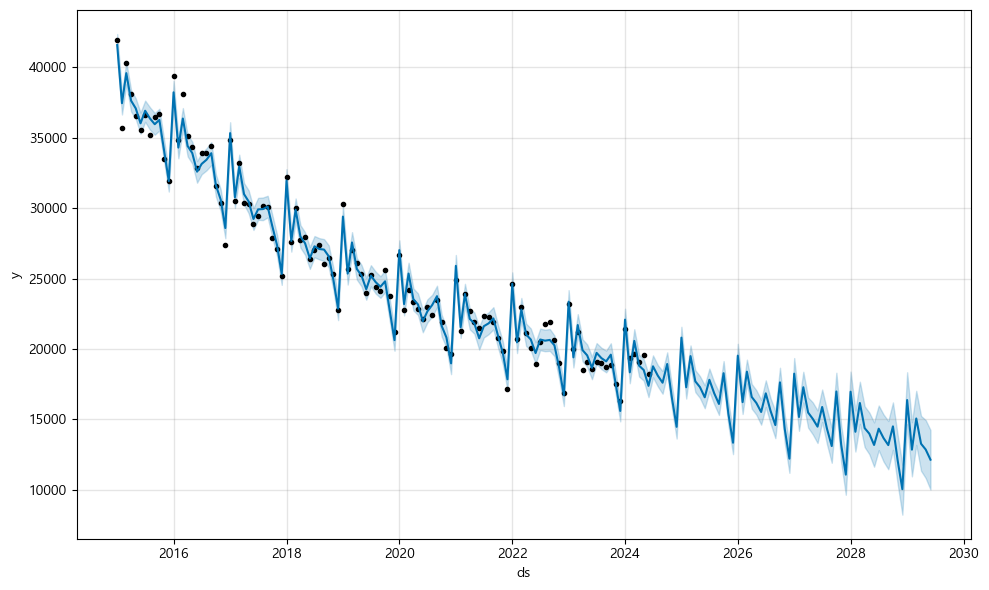

In [87]:
# 전체 10년 데이터(최신 데이터인 트레인 셋을 포함시켜)로 미래 5년 재예측 
df1 = pd.DataFrame({'ds': df['Date'], 'y': df['출생아수']})

# Prophet 모델 생성
model = Prophet()

# 데이터 학습 (2015.01~2024.06월까지의 데이터로)
model.fit(df1)

# 2024.07월부터 미래의 60개월 데이터를 생성하여 뒤에 붙임  (365일 일 별 대신 월 별 기간을 사용)
future = model.make_future_dataframe(periods=60, freq='M')  

# 미래 데이터 출력 확인 
print(future.tail())

# 예측
forecast = model.predict(future)

# 예측 결과 확인(표와 그래프로로)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fig1 = model.plot(forecast)
plt.show() 

In [ ]:
# 계절성을 반영한 SARIMA 모델

import pandas as pd

df=pd.read_excel('human.xlsx')

date_row = df.iloc[0, 4:]  # 날짜 정보는 5번째 열부터 시작
birth_row = df.iloc[1, 4:] 

birth_data = pd.DataFrame({
    'Date': date_row,
    '출생아수': birth_row
})

birth_data_cleaned = birth_data.dropna()

# 결과 출력
birth_data_cleaned.set_index('Date')

,출생아수
Date,
2015.01 월,41914
2015.02 월,35709
2015.03 월,40329
2015.04 월,38072
2015.05 월,36534
...,...
2024.02 월,19362
2024.03 월,19669
2024.04 월,19049


In [35]:
from pmdarima import auto_arima

# 모델 파라미터 자동 탐색 (train set을 가지고)
auto_model = auto_arima(df2['y'], 
                        seasonal=True, m=12,  # 계절성 주기 12개월
                        trace=True,           # 탐색 과정 출력
                        error_action='ignore', 
                        suppress_warnings=True)

print(auto_model.summary())
print(f"\nBest Model AIC: {auto_model.aic()}")
print(f"Best Model Parameters: {auto_model.get_params()['order']} {auto_model.get_params()['seasonal_order']}")


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1648.650, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1776.239, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1672.348, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1711.039, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1775.130, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1712.247, Time=0.13 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1688.045, Time=0.22 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1661.481, Time=0.80 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=1663.808, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1695.149, Time=0.35 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=1669.823, Time=0.45 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept

In [36]:
import statsmodels.api as sm

df2['y'] = pd.to_numeric(pd.to_numeric(df2['y']))

# SARIMA 모델 적합
sarima_model = sm.tsa.statespace.SARIMAX(df2['y'], 
                                  order=(2,1,2), 
                                  seasonal_order=(1, 0, 1, 12),
                                  enforce_invertibility=False,
                                  enforce_stationarity=False)
#P,D,Q
#m :월별 데이터이므로 계절 주기는 12로 설정
sarima_fit = sarima_model.fit()

# 18 단위 예측
forecast1 = sarima_fit.forecast(steps=18)
print(forecast1)

96     22606.870853
97     19459.413183
98     21104.961217
99     19877.622032
100    19295.451515
101    18527.060487
102    19313.007641
103    19441.630620
104    19482.520348
105    18783.252028
106    17601.489618
107    15956.832971
108    21054.255491
109    18075.456994
110    19597.515071
111    18451.615185
112    17908.606491
113    17192.655036
Name: predicted_mean, dtype: float64


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 530349.6750322382
RMSE: 728.2511071273688
MAE: 551.0125981242704
Mean Absolute Percentage Error (MAPE): 2.87%


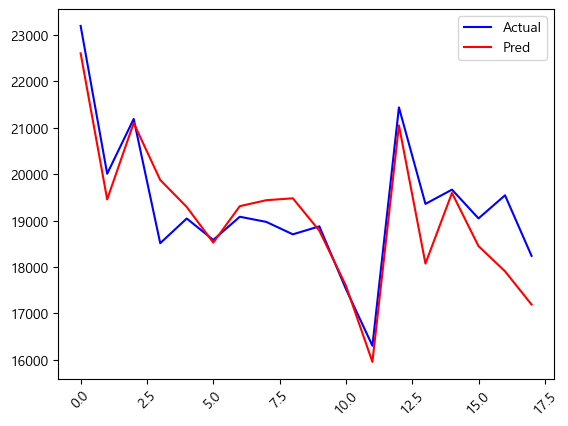

In [65]:
forecast2

df4 = pd.DataFrame({'actual' : df3['y'].values , 'pred' : forecast1.values})
import matplotlib.pyplot as plt
plt.plot(df4['actual'], label='Actual', color='blue')
plt.plot(df4['pred'], label='Pred', color='red')
plt.legend()
plt.xticks(rotation=45)


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(df4['actual'], df4['pred'])  # MSE
rmse = np.sqrt(mse)  # RMSE
mae = mean_absolute_error(df4['actual'], df4['pred'])
mape = (abs((df4['actual'] - df4['pred']) / df4['actual']).mean()) * 100

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
#MAPE가 2.87퍼센트이기 때문에 상당히 좋은 모델이라고 할 수있음.

In [40]:
# 전체 데이터로 적합
import statsmodels.api as sm

birth_data_cleaned['출생아수'] = pd.to_numeric(pd.to_numeric(birth_data_cleaned['출생아수']))

# SARIMA 모델 적합
sarima_model = sm.tsa.statespace.SARIMAX(birth_data_cleaned['출생아수'], 
                                  order=(2,1,2), 
                                  seasonal_order=(1, 0, 1, 12),
                                  enforce_invertibility=False,
                                  enforce_stationarity=False)
#P,D,Q
#m :월별 데이터이므로 계절 주기는 12로 설정
sarima_fit = sarima_model.fit()

# 5년(60개월) 예측
forecast2 = sarima_fit.forecast(steps=60)

print(forecast2)

2024-07-01    18506.303123
2024-08-01    18350.724343
2024-09-01    18384.828999
2024-10-01    17900.465446
2024-11-01    16891.457692
2024-12-01    15748.295365
2025-01-01    20035.778299
2025-02-01    17488.454352
2025-03-01    18699.838263
2025-04-01    17595.096715
2025-05-01    17340.183092
2025-06-01    16736.050813
2025-07-01    17156.759328
2025-08-01    17034.035378
2025-09-01    17086.038188
2025-10-01    16641.371540
2025-11-01    15718.789774
2025-12-01    14669.870699
2026-01-01    18602.540749
2026-02-01    16266.156862
2026-03-01    17377.244720
2026-04-01    16364.012570
2026-05-01    16130.235788
2026-06-01    15576.155601
2026-07-01    15962.007248
2026-08-01    15849.450921
2026-09-01    15897.145364
2026-10-01    15489.323370
2026-11-01    14643.186477
2026-12-01    13681.180372
2027-01-01    17287.990960
2027-02-01    15145.198907
2027-03-01    16164.222469
2027-04-01    15234.946332
2027-05-01    15020.540203
2027-06-01    14512.370881
2027-07-01    14866.251013
2

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Valu

In [51]:
forecast2_df = pd.DataFrame({
    'Date': forecast2.index,
    '출생아수': forecast2.values
})

# Date를 문자열에서 datetime 형식으로 변환
forecast2_df['Date'] = pd.to_datetime(forecast2_df['Date'])
forecast2_df.set_index('Date', inplace=True)

# 두 데이터프레임을 결합
combined_data = pd.concat([birth_data_cleaned, forecast2_df])

# 결합된 데이터 확인
print(combined_data.tail())  # 결합된 데이터의 마지막 몇 개의 행을 확인

# Date 열을 datetime 형식으로 변환하고 시간대 정보를 제거(수업시간에 배운 것)
combined_data.index = pd.to_datetime(combined_data.index).tz_localize(None)



                             출생아수
Date                             
2029-02-01 00:00:00  13174.233224
2029-03-01 00:00:00  14031.381332
2029-04-01 00:00:00  13249.723957
2029-05-01 00:00:00  13069.376990
2029-06-01 00:00:00  12641.932141
                    출생아수
Date                    
2015-01-01  41914.000000
2015-02-01  35709.000000
2015-03-01  40329.000000
2015-04-01  38072.000000
2015-05-01  36534.000000
...                  ...
2029-02-01  13174.233224
2029-03-01  14031.381332
2029-04-01  13249.723957
2029-05-01  13069.376990
2029-06-01  12641.932141

[174 rows x 1 columns]


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_16196\1621479744.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_data.index = pd.to_datetime(combined_data.index).tz_localize(None)


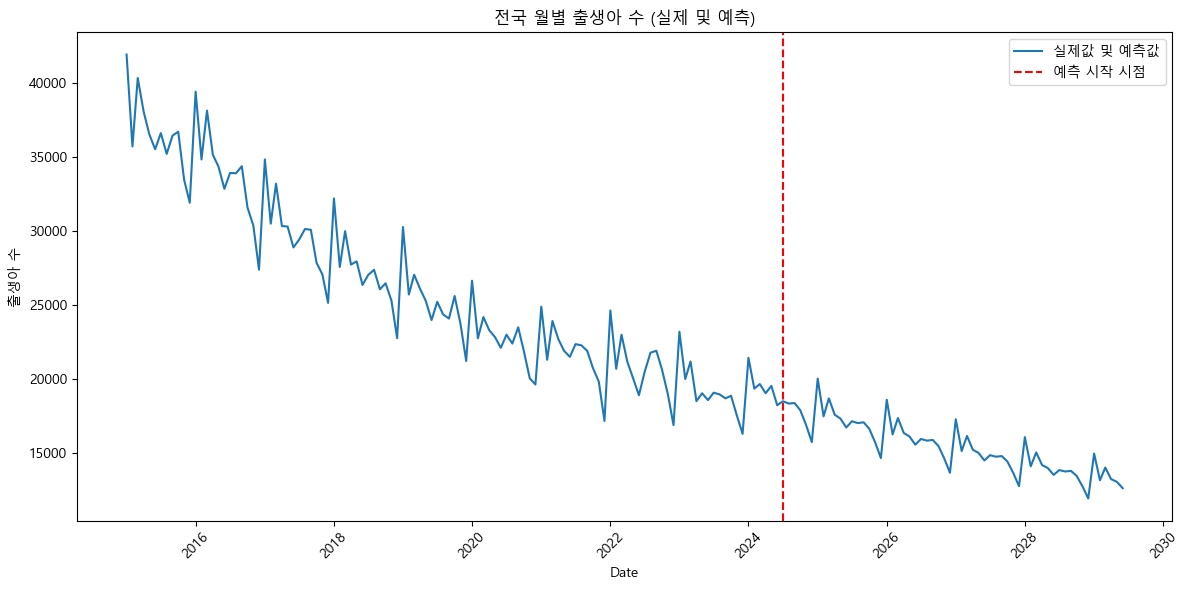

In [52]:
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['출생아수'], label='실제값 및 예측값')
plt.axvline(x=pd.to_datetime('2024-07-01'), color='red', linestyle='--', label='예측 시작 시점')  # 예측 시작 시점을 시각적으로 표시
plt.title('전국 월별 출생아 수 (실제 및 예측)')
plt.xlabel('Date')
plt.ylabel('출생아 수')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


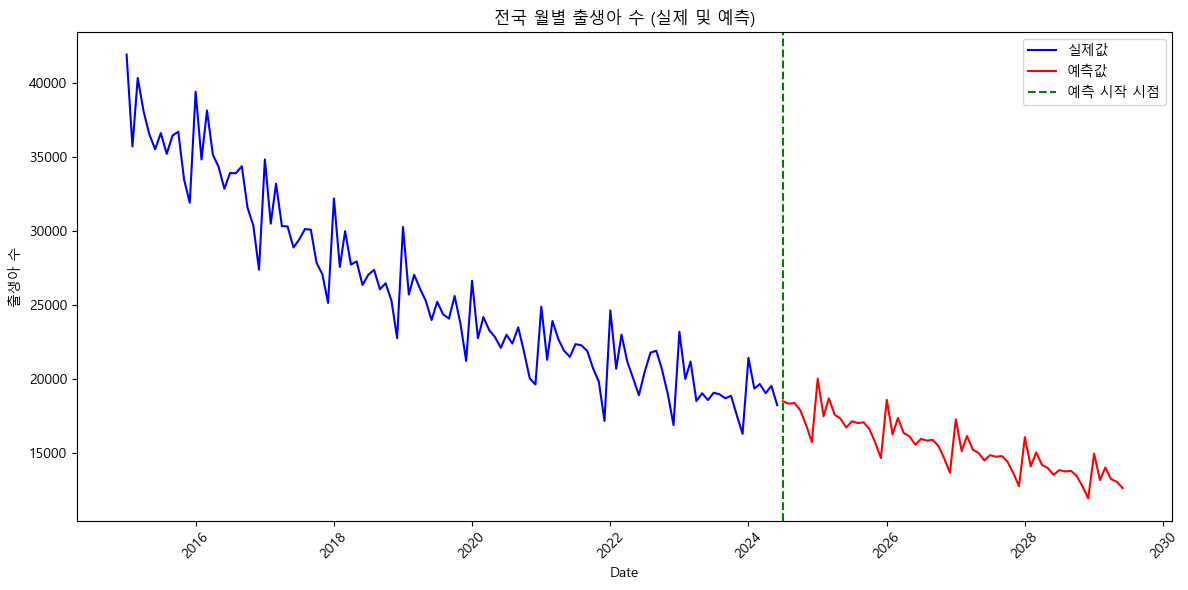

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# 2024년 7월 1일(예측 시작시점)을 기준으로 데이터 분할해서 저장
split_date = pd.to_datetime('2024-07-01')
before_forecast = combined_data[combined_data.index < split_date]
after_forecast = combined_data[combined_data.index >= split_date]

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(before_forecast.index, before_forecast['출생아수'], label='실제값', color='blue')
plt.plot(after_forecast.index, after_forecast['출생아수'], label='예측값', color='red')
plt.axvline(x=split_date, color='green', linestyle='--', label='예측 시작 시점')

# 제목, 라벨링
plt.title('전국 월별 출생아 수 (실제 및 예측)')
plt.xlabel('Date')
plt.ylabel('출생아 수')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
